# Alveoli and acinar size
This document is used to plot the acinar volumes and stereological counts for the alveolar manuscript.

In [1]:
# Assess coding style, based on https://stackoverflow.com/a/47204361/323100

# %load_ext pycodestyle_magic
# and then put '%%pycodestyle' in the cells

# Or do it like so from the Terminal:
# jupyter nbconvert Acinar\ and\ alveolar\ number.ipynb --to script  && pycodestyle *.py --ignore=E501 --show-source

First, we set up the notebook.

In [2]:
# Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import timeit
import numpy

In [3]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [4]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook'
      % the_current_git_hash)

We are working with version 11bcf54 of the analyis notebook


In [5]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.transparent'] = True  # Save figures with transparent background

In [6]:
# Make us an output folder (including the git hash, so we (potentially) have different versions of the images)
imgdir = os.path.join('img', the_current_git_hash)
os.makedirs(imgdir, exist_ok=True)

Now we load the 'Count' data from Eveline.

In [7]:
# # Different locations if running either on Linux or Windows
# if 'debian' in platform.dist():
#     drive = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny')
# else:
#     drive = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data')
# # Load the data from this folder
# RootPath = os.path.join(drive, 'doc', 'David')
# print('We are loading all the data from %s' % RootPath)

In [8]:
# We copied everything from nas_schittny and the terastation to 'fast SSD'.
# Load the data from there
if 'debian' in platform.dist():
    drive = '/media/habi/Fast_SSD/'
else:
    drive = 'F:/'
# Load the data from this folder
RootPath = drive + os.path.join('Acini')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /media/habi/Fast_SSD/Acini


In [9]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles_Eveline = sorted(glob.glob(os.path.join(RootPath, '**/*201[1234567]*.xls'), recursive=True))

In [10]:
print('Eveline counted the alveoli in %s acini' % len(StepanizerFiles_Eveline))

Eveline counted the alveoli in 287 acini


In [11]:
# # Grab relevant data from filenames
# for f in StepanizerFiles_Eveline:
#     print('Animal', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3])
#     print('Day', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2])
#     print('Acinus', os.path.basename(f).split('acinus')[1].split('_')[0])

In [12]:
# Generate dataframe to save Evelines assessment
Eveline = pandas.DataFrame({'Location': StepanizerFiles_Eveline})
Eveline['Filename'] = [os.path.basename(f) for f in StepanizerFiles_Eveline]
Eveline['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_Eveline]
Eveline['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_Eveline]
Eveline['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_Eveline]
Eveline['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_Eveline]
Eveline['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_Eveline]
Eveline['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles_Eveline]
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...
Eveline['Pixelsize'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                              skiprows=16, header=None, usecols=[0, 1], nrows=1)[1][0])
                        for f in StepanizerFiles_Eveline]
# Count the images in their respective folders
Eveline['Number of images'] = [[int(os.path.basename(i).split('_')[-2]) for
                                i in glob.glob(os.path.join(os.path.dirname(location),
                                                            '*.jpg'))] for
                               location in Eveline.Location]
Eveline['Number of images'] = [max(li) for li in Eveline['Number of images']]

In [13]:
Eveline.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%    max
Day Animal                                                                    
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00  111.0
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00  171.0
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00  249.0
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00  245.0
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25  199.0
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00  505.0
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00  781.0
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00  493.0
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50  572.0
60  60B      24.0  350.875000  115.473058  161.0  253.25  364.0  424.50  648.0
    60C      20.0  103.800000   60.113577   30.0   68.00   86.0  127.00  270.0
    60D      10.0  363.700000   99.473112  222.0  299.25  368.5  390.00  591.0
    60E       9.0  395.777778  134.458895  136.0  368.00  370.0  472.00  602.0

In [14]:
# Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 3)].head()

In [15]:
# Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 4)].head()

In [16]:
# For D60, Eveline counted only half of the images, we thus double the 'counts'
Eveline.loc[Eveline.Animal == '60B', 'Counts'] = 2 * Eveline['Counts']
# For Animal 60C she counted *every* image, we thus don't double there!
Eveline.loc[Eveline.Animal == '60D', 'Counts'] = 2 * Eveline['Counts']
Eveline.loc[Eveline.Animal == '60E', 'Counts'] = 2 * Eveline['Counts']
# For two acini (acinus 3 for 60D and acinus 12 for 60E) Eveline counted every image
Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 3), 'Counts'] = 0.5 * Eveline['Counts']
Eveline.loc[(Eveline.Animal == '60E') & (Eveline.Acinus == 12), 'Counts'] = 0.5 * Eveline['Counts']
# The 'number of images' (read below) stays the same, since Eveline just skipped the images in STEPanizer!

In [17]:
# Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 4)].head()

In [18]:
# Eveline.loc[(Eveline.Animal == '60E')]

In [19]:
Eveline.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%  \
Day Animal                                                                
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00   
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00   
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00   
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00   
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25   
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00   
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00   
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00   
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50   
60  60B      24.0  701.750000  230.946116  322.0  506.50  728.0  849.00   
    60C      20.0  103.800000   60.113577   30.0   68.00   86.0  127.00   
    60D      10.0  668.300000  121.669909  444.0  569.25  722.0  747.00   
    60E       9.0  739.111111  281.215418  272.0  640.00  738.0  770.00   

               max  
Day Animal          
4   04A      111.0  
    04B      171.0  
    04C      249.0  
10  10A      245.0  
    10B      199.0  
    10C      505.0  
21  21B      781.0  
    21D      493.0  
    21E      572.0  
60  60B     1296.0  
    60C      270.0  
    60D      810.0  
    60E     1204.0

In [20]:
# Describe counts
for d in sorted(Eveline.Day.unique()):
    print('Details of day %s' % d)
    print(Eveline.loc[Eveline.Day == d].groupby(by=['Day', 'Animal'])['Counts'].describe())
    print(80 * '-')

Details of day 4
            count       mean        std   min    25%   50%   75%    max
Day Animal                                                             
4   04A      50.0  27.040000  23.687558   4.0  11.25  17.5  35.0  111.0
    04B      23.0  65.043478  43.849410  15.0  34.50  53.0  80.0  171.0
    04C      51.0  60.509804  45.424387  10.0  29.50  52.0  77.0  249.0
--------------------------------------------------------------------------------
Details of day 10
            count        mean         std   min   25%   50%     75%    max
Day Animal                                                                
10  10A      27.0   77.851852   56.305283  18.0  28.5  69.0  122.00  245.0
    10B      14.0   84.571429   65.752115  23.0  37.5  52.0  135.25  199.0
    10C      17.0  108.764706  125.449955  15.0  46.0  73.0  105.00  505.0
--------------------------------------------------------------------------------
Details of day 21
            count        mean         std    min  

In [21]:
# What's the mean count for the days?
for d in sorted(Eveline.Day.unique()):
    print('The mean count (alveolar number) at day %02s is %6.2f (+- %6.2f STD)' % (d,
                                                                                    Eveline.loc[Eveline.Day == d]['Counts'].mean(),
                                                                                    Eveline.loc[Eveline.Day == d]['Counts'].std()))

The mean count (alveolar number) at day  4 is  47.85 (+-  41.28 STD)
The mean count (alveolar number) at day 10 is  88.53 (+-  83.84 STD)
The mean count (alveolar number) at day 21 is 233.33 (+- 164.30 STD)
The mean count (alveolar number) at day 60 is 511.95 (+- 335.20 STD)


In [22]:
# Get a list of *all* the excel files *I* counted are from the STEPanizer
# Since we only counted in 2018, we can filter to this year in the file name.
StepanizerFiles_David = sorted(glob.glob(os.path.join(RootPath, '**/*2018*.xls'), recursive=True))

In [23]:
print('David assessed the disector volume in %s acini' % len(StepanizerFiles_David))

David assessed the disector volume in 287 acini


In [24]:
# Copied verbatim from ReadVolumeSurfaceAndAlveaolarNumber.py
DisectorThickness = 5    # slices
TOMCATPixelSize = 1.48   # um
ShrinkageFactor = 0.61   # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement

In [25]:
David = pandas.DataFrame({'Location': StepanizerFiles_David})
David['Filename'] = [os.path.basename(f) for f in StepanizerFiles_David]
David['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_David]
David['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_David]
David['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_David]
David['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_David]
David['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_David]
David['Counts'] = [int(pandas.read_csv(f, nrows=13,
                                       delimiter='\t')['Total'][10]) for f in StepanizerFiles_David]
David['Pixelsize'] = [float(pandas.read_csv(f, skiprows=16, nrows=1, delimiter='\t', encoding='latin',
                                            header=None, usecols=[1])[1]) for f in StepanizerFiles_David]
David['Area per point'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=28, header=None, usecols=[0, 1],
                                                 nrows=1)[1][0]) for f in StepanizerFiles_David]
David['Acinusvolume'] = [cts * ap * 2 * DisectorThickness * TOMCATPixelSize / 1e9 for cts, ap in zip(David['Counts'],
                                                                                                     David['Area per point'])]  # from um^3 to mm^3
# Read the number of images from the xls-file instead of counting from disk
# Might be good for error-checking...
David['Number of images'] = [int(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=12, header=None, usecols=[0, 1, 2, 3],
                                                 nrows=1)[2][0][2:])  # Stefan writes '->NumImg' into the cell, so we read only everything from string position 3 on...
                             for f in StepanizerFiles_David]

In [26]:
# Salm zu Barré (d21)
NumAlveoli = 14.303 * 1e6
NumAcini = 5840
print(NumAlveoli / NumAcini)

2449.1438356164385


In [27]:
David[David.Day == 21]['Acinusvolume'].mean() * 1e-12 * NumAcini

6.0689440772140947e-10

In [28]:
# Merge 'Eveline' and 'David' to evaluate the data
# See the 'DisectorVolumes' notebook for which acini remain to count!
# Based on https://stackoverflow.com/a/33350050/323100
Done = pandas.merge(Eveline, David,
                    on=['Animal', 'Acinus', 'Day', 'Beamtime', 'Sample'],
                    how='inner', suffixes=['_Eveline', '_David'],
                    indicator=True)
print('We have the data of %s acini...' % len(Done))
print('We thus still need to count approximately %s acini...' % (len(Eveline) - len(David)))

We have the data of 287 acini...
We thus still need to count approximately 0 acini...


In [29]:
Done.head()

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,Location_David,Filename_David,Counts_David,Pixelsize_David,Area per point,Acinusvolume,Number of images_David,_merge
0,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus03_2012-06-11_11-49_resul...,2009f,R108C60Dt-mrg,60D,60,3,591.0,2.44,93,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus03_2018-01-26_12-57_resul...,526,2.00,141125.44,1.098633,93,both
1,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus04_2012-10-19_11-56_resul...,2009f,R108C60Dt-mrg,60D,60,4,750.0,2.17,132,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus04_2018-02-26_16-09_resul...,816,1.92,130478.41,1.575762,132,both
2,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus07_2012-08-14_15-33_resul...,2009f,R108C60Dt-mrg,60D,60,7,738.0,1.35,120,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus07_2018-02-23_12-47_resul...,938,1.15,46612.98,0.647100,120,both
3,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus09_2012-08-14_17-21_resul...,2009f,R108C60Dt-mrg,60D,60,9,554.0,1.49,124,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus09_2018-02-27_15-16_resul...,953,1.25,55127.13,0.777535,124,both
4,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus10_2012-08-20_16-23_resul...,2009f,R108C60Dt-mrg,60D,60,10,562.0,1.41,110,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus10_2018-02-26_16-28_resul...,814,1.16,47703.30,0.574691,110,both


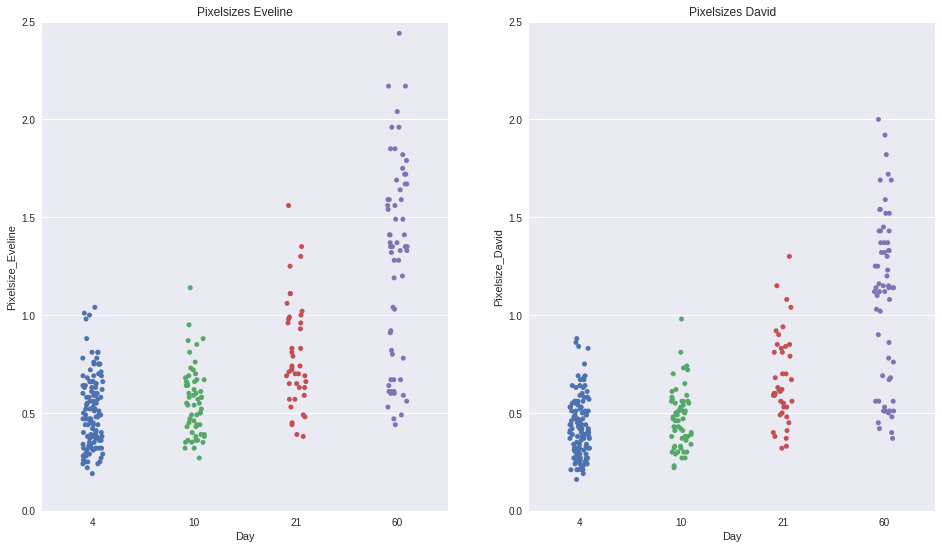

In [30]:
# Compare data
plt.subplot(121)
seaborn.stripplot(data=Done, x='Day', y='Pixelsize_Eveline', jitter=True)
plt.ylim([0, 2.5])
plt.title('Pixelsizes Eveline')
plt.subplot(122)
seaborn.stripplot(data=Done, x='Day', y='Pixelsize_David', jitter=True)
plt.title('Pixelsizes David')
plt.ylim([0, 2.5])
plt.show()

In [31]:
# Set ourselves a palette, based on the individual unique sample names
# The dictionary palette setting is based on the comments in https://stackoverflow.com/q/36554075/323100
ourcolors = seaborn.color_palette('husl', len(pandas.unique(Eveline.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(pandas.unique(Eveline.Animal))}

In [32]:
# Set indivdual measurement color (in dataframe)
Eveline['Color'] = [None] * len(Eveline)
for c, animal in enumerate(Eveline.Animal):
    for d, i in enumerate(pandas.unique(Eveline.Animal)):
        if animal == i:
            Eveline.set_value(c, 'Color', ourcolors[d])

Load the volume data directly from `anatera4`, where I originally exported the DICOM files from MeVisLab (and where the data still is).
After doing that, we save it to a dataframe on disk, since looking for all the DICOM files takes nearly an hour...

In [33]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    drive = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    drive = '\\\\anatera4\\'
# Load the data from this folder
terastation = drive + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [34]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Volumes = 'VolumesFromDisk_' + get_git_hash() + '.pkl'

In [35]:
useoldvolumefile = True
if useoldvolumefile:
    try:
        # Use the *newest* VolumesFromDisk file, even if it's from another git hash
        OutputName_Volumes = max(glob.iglob('VolumesFromDisk*.pkl'), key=os.path.getctime)
    except ValueError:
        useoldvolumefile = False
        print('We *need* to generate a new volume file, since we found none...')

In [36]:
if get_git_hash() != os.path.splitext(OutputName_Volumes.split('_')[1])[0]:
    print('Hash (%s) is not the same as OutputName_Volumes (%s)!' % (get_git_hash(), OutputName_Volumes))
    print('We are using the old file: %s' % OutputName_Volumes)
else:
    print('Hash (%s) is equal to the name of the OutputName_Volumes file name (%s)!' % (get_git_hash(), OutputName_Volumes))

Hash (11bcf54) is equal to the name of the OutputName_Volumes file name (VolumesFromDisk_11bcf54.pkl)!


In [37]:
# Get a list of *all* DICOM files that I exported aeons ago
# Based on https://stackoverflow.com/a/14798263
# This takes between 30 and 60 minutes!!!
# We thus only do it if we cannot read the dataframe with all the data that we save later on...
if os.path.exists(OutputName_Volumes):
    print('We load the data from %s' % OutputName_Volumes)
else:
    print('We scan %s for "R108*.dcm" files' % terastation)
    tic = timeit.default_timer()
    AcinarVolumeFiles = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
    toc = timeit.default_timer()
    print('We found %s DICOM files in %s minutes' % (len(AcinarVolumeFiles),
                                                     round(float((toc - tic) / 60.), 1)))

We load the data from VolumesFromDisk_11bcf54.pkl


In [38]:
# Collect the data into a dataframe
if os.path.exists(OutputName_Volumes):
    # We already did it once, so just load it...
    VolumesFromDisk = pandas.read_pickle(OutputName_Volumes)
else:
    # Save the file locations into an empty dataframe
    VolumesFromDisk = pandas.DataFrame({'Location_Volume': AcinarVolumeFiles})

In [39]:
# # Grab relevant data from filenames (used to get the string matching right...)
# for f in AcinarVolumeFiles:
#     print(os.path.basename(f))
#     print('Animal', os.path.basename(f).split('R108C')[1].split('mrg.')[0][:-2])
#     print('Day', os.path.basename(f).split('R108C')[1].split('mrg')[0][:2])
#     print('Acinus', os.path.basename(f).split('.acinus')[1].split('.volume')[0])
#     print('Volume_MeVisLab', os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
#     print('Scantime', os.path.dirname(f).split('SLS')[1].split(os.sep)[1])
#     print(80*'-')

In [40]:
# # Some names (see output of this cell) derive from the R108C$Day$$Animal$ scheme.
# # We catch them with the intricate .split() in the cells below...
# for i in VolumesFromDisk.File:
#     if len(i.split('mrg')[0][len('R108C'):-2]) >3:
#         tmp.append(i.split('mrg')[0][len('R108C'):-2])
# for i in pandas.unique(tmp):
#     print(i)

In [41]:
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk['Filename_Volume'] = [os.path.basename(f) for f in AcinarVolumeFiles]
    VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+3]
                                 for f in AcinarVolumeFiles]
    VolumesFromDisk['Beamtime'] = [os.path.dirname(f).split('SLS')[1].split(os.sep)[1]
                                   for f in AcinarVolumeFiles]
    VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+2])
                              for f in AcinarVolumeFiles]
    VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                                 for f in AcinarVolumeFiles]
    # According to the MeVisLab files, the volume is saved to the file name in 'ul'.
    # To get cm³ we divide by 1000
    VolumesFromDisk['Volume_MeVisLab'] = [float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0]) / 1000
                                          for f in AcinarVolumeFiles]  # cm³

In [42]:
# Drop Day 36
# https://stackoverflow.com/a/27360130/323100
VolumesFromDisk.drop(VolumesFromDisk[VolumesFromDisk['Day']==36].index, inplace=True)
print('If we drop day 36, we now have %s acini' % len(VolumesFromDisk))

If we drop day 36, we now have 702 acini


In [43]:
# Save the data and give some feedback.
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk.to_pickle(OutputName_Volumes)

In [44]:
VolumesFromDisk.groupby(by=['Day', 'Animal'])['Volume_MeVisLab'].describe()

count      mean       std           min       25%       50%  \
Day Animal                                                                
4   04A      51.0  0.000006  0.000005  9.182831e-07  0.000002  0.000004   
    04B      23.0  0.000035  0.000035  6.500183e-06  0.000014  0.000023   
    04C      51.0  0.000029  0.000025  4.332695e-06  0.000013  0.000024   
    04D      44.0  0.000024  0.000024  3.993681e-06  0.000009  0.000017   
    04E      43.0  0.000011  0.000009  1.216217e-06  0.000004  0.000009   
10  10A      32.0  0.000018  0.000012  2.227656e-06  0.000007  0.000015   
    10B      27.0  0.000017  0.000014  3.091166e-06  0.000006  0.000013   
    10C      69.0  0.000029  0.000034  1.266426e-06  0.000008  0.000016   
    10D      34.0  0.000020  0.000012  5.223176e-06  0.000012  0.000016   
    10E      33.0  0.000011  0.000008  2.034290e-06  0.000005  0.000007   
21  21A      24.0  0.000043  0.000037  3.040957e-06  0.000018  0.000030   
    21B      42.0  0.000047  0.000038  6.526948e-06  0.000019  0.000040   
    21D      94.0  0.000069  0.000083  1.511868e-06  0.000021  0.000034   
    21E      51.0  0.000079  0.000068  7.257673e-06  0.000035  0.000062   
60  60B      24.0  0.000319  0.000133  1.339540e-04  0.000225  0.000306   
    60C      41.0  0.000039  0.000029  5.616134e-06  0.000018  0.000030   
    60D      10.0  0.000434  0.000128  2.322982e-04  0.000322  0.000441   
    60E       9.0  0.000460  0.000226  1.248685e-04  0.000337  0.000512   

                 75%       max  
Day Animal                      
4   04A     0.000008  0.000022  
    04B     0.000034  0.000121  
    04C     0.000038  0.000135  
    04D     0.000027  0.000108  
    04E     0.000013  0.000046  
10  10A     0.000026  0.000049  
    10B     0.000020  0.000052  
    10C     0.000036  0.000172  
    10D     0.000026  0.000053  
    10E     0.000017  0.000030  
21  21A     0.000065  0.000144  
    21B     0.000057  0.000216  
    21D     0.000083  0.000393  
    21E     0.000104  0.000347  
60  60B     0.000427  0.000667  
    60C     0.000046  0.000131  
    60D     0.000545  0.000590  
    60E     0.000671  0.000752

In [45]:
print('MeVisLab Volumes\n')
# Give out alveolar volumes per day
for day in sorted(Eveline.Day.unique()):
    print('Day %02d' % day)
    cts = numpy.mean(Eveline.loc[Eveline.Day == day]['Counts'])
    print('Mean count from Eveline: %4.2f' % cts)
    # Volume (natütterli mit Ductus und so...)
    vol = numpy.mean(VolumesFromDisk.loc[VolumesFromDisk.Day == day]['Volume_MeVisLab']) * 1e12
    print('Mean volume (MeVisLab): %4.3g ul' % vol)
    # Mit Schrumpfung
    print('Volume per counts / 0.6: %4.3g' % ((vol / cts) / 0.6))
    # Volumen --> Radius
    # v = 4/3 * pi * r^3
    # r = ((3/4) * v / pi ) ^ 1/3
    # r * 2 = diameter
    print('Mean diameter of one alveolus: %4.2f um' % (2 * (numpy.cbrt(3 / 4 * vol / numpy.pi))))
    print(80*'-')
# https://www.wolframalpha.com/input/?i=sphere+with+volume+of+2.11e%2B08+ul

MeVisLab Volumes

Day 04
Mean count from Eveline: 47.85
Mean volume (MeVisLab): 1.95e+07 ul
Volume per counts / 0.6: 6.79e+05
Mean diameter of one alveolus: 333.88 um
--------------------------------------------------------------------------------
Day 10
Mean count from Eveline: 88.53
Mean volume (MeVisLab): 2.07e+07 ul
Volume per counts / 0.6: 3.89e+05
Mean diameter of one alveolus: 340.55 um
--------------------------------------------------------------------------------
Day 21
Mean count from Eveline: 233.33
Mean volume (MeVisLab): 6.38e+07 ul
Volume per counts / 0.6: 4.56e+05
Mean diameter of one alveolus: 495.81 um
--------------------------------------------------------------------------------
Day 60
Mean count from Eveline: 511.95
Mean volume (MeVisLab): 2.11e+08 ul
Volume per counts / 0.6: 6.88e+05
Mean diameter of one alveolus: 738.86 um
--------------------------------------------------------------------------------


In [46]:
print('Stepanizered Volumes\n')
# Give out alveolar volumes per day
for day in sorted(Eveline.Day.unique()):
    print('Day %02d' % day)
    cts = numpy.mean(Eveline.loc[Eveline.Day == day]['Counts'])
    print('Mean count from Eveline: %4.2f' % cts)
    # Volume (natütterli mit Ductus und so...)
    vol = numpy.mean(David.loc[David.Day == day]['Acinusvolume']) * 1e9
    print('Mean volume (STEPanizer): %4.3g ul' % vol)
    # Mit Schrumpfung
    print('Volume per counts / 0.6: %4.3g' % ((vol / cts) / 0.6))
    # Volumen --> Radius
    # v = 4/3 * pi * r^3
    # r = ((3/4) * v / pi ) ^ 1/3
    # r * 2 = diameter
    print('Mean diameter of one alveolus: %4.2f um' % (2 * (numpy.cbrt(3 / 4 * vol / numpy.pi))))
    print(80*'-')
# https://www.wolframalpha.com/input/?i=sphere+with+volume+of+2.11e%2B08+ul

Stepanizered Volumes

Day 04
Mean count from Eveline: 47.85
Mean volume (STEPanizer): 3.29e+07 ul
Volume per counts / 0.6: 1.14e+06
Mean diameter of one alveolus: 397.38 um
--------------------------------------------------------------------------------
Day 10
Mean count from Eveline: 88.53
Mean volume (STEPanizer): 4e+07 ul
Volume per counts / 0.6: 7.54e+05
Mean diameter of one alveolus: 424.47 um
--------------------------------------------------------------------------------
Day 21
Mean count from Eveline: 233.33
Mean volume (STEPanizer): 1.04e+08 ul
Volume per counts / 0.6: 7.42e+05
Mean diameter of one alveolus: 583.31 um
--------------------------------------------------------------------------------
Day 60
Mean count from Eveline: 511.95
Mean volume (STEPanizer): 5.21e+08 ul
Volume per counts / 0.6: 1.7e+06
Mean diameter of one alveolus: 998.58 um
--------------------------------------------------------------------------------


In [47]:
# Update palette, since we might have more animals than what we had above in cell 19
ourcolors = seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(VolumesFromDisk.Animal)))}

In [48]:
# seaborn.violinplot(data=Eveline, x='Day', y='Counts', cut=0, scale='count',
#                    palette=seaborn.color_palette('husl', len(pandas.unique(Eveline.Day))),
#                    inner='quartiles')
# seaborn.stripplot(data=Eveline, x='Day', y='Counts', linewidth=1, jitter=True,
#                   palette=seaborn.color_palette('husl', len(pandas.unique(Eveline.Day))),
#                   edgecolor='k', alpha=0.309)
# plt.title('Bridge counts')
# plt.ylim(ymin=0)
# plt.savefig(os.path.join(imgdir, 'counts_global.png'), bbox_inches='tight')
# plt.show()

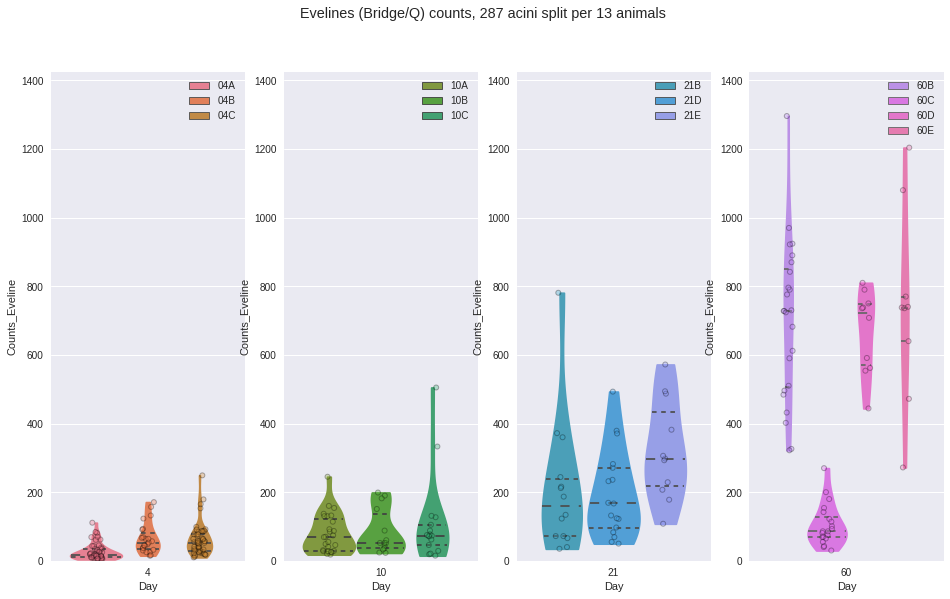

In [49]:
for c, d in enumerate(sorted(pandas.unique(Eveline.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_Eveline',
                               hue='Animal',
                               # Because the animals are preferentially sorted on the beamtime name, we have
                               # to jump through the hoop below and sort the hues on the 'Animal' in addition
                               # to what we did for Evelines counts where all the data is in *one* folder
                               # Just comment the next line to see the difference (a correct plot, but ugly sort :)
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_Eveline', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done.Counts_Eveline.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Evelines (Bridge/Q) counts, %s acini split per %s animals' % (len(Eveline),
                                                                            len(pandas.unique(Eveline.Animal))))
plt.savefig(os.path.join(imgdir, 'counts_day-eveline.png'), bbox_inches='tight')
plt.show()

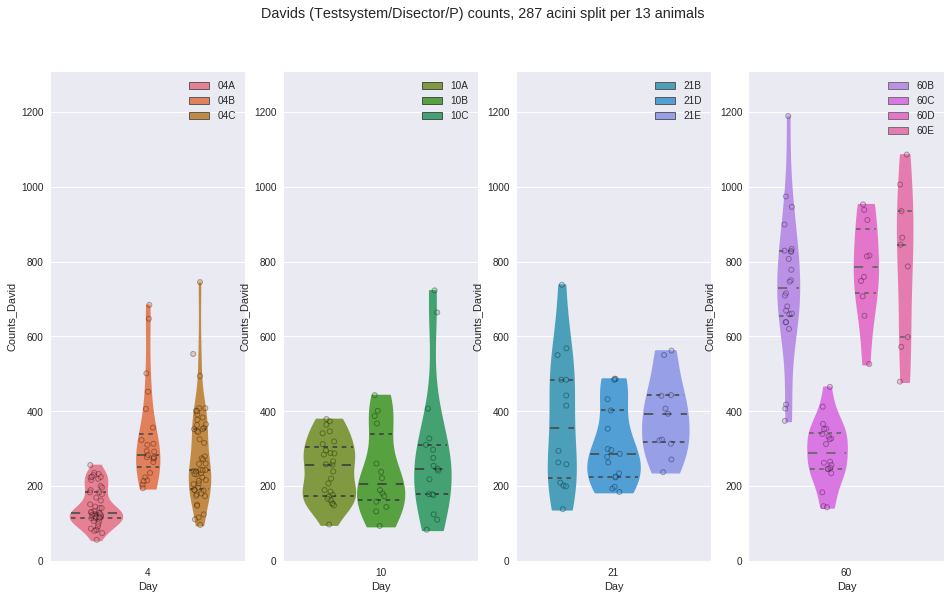

In [50]:
for c, d in enumerate(sorted(pandas.unique(Done.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_David',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_David', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done.Counts_David.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2], loc='upper right')
plt.suptitle('Davids (Testsystem/Disector/P) counts, %s acini split per %s animals' % (len(David),
                                                                                       len(pandas.unique(David.Animal))))
plt.savefig(os.path.join(imgdir, 'counts_day-david.png'), bbox_inches='tight')
plt.show()

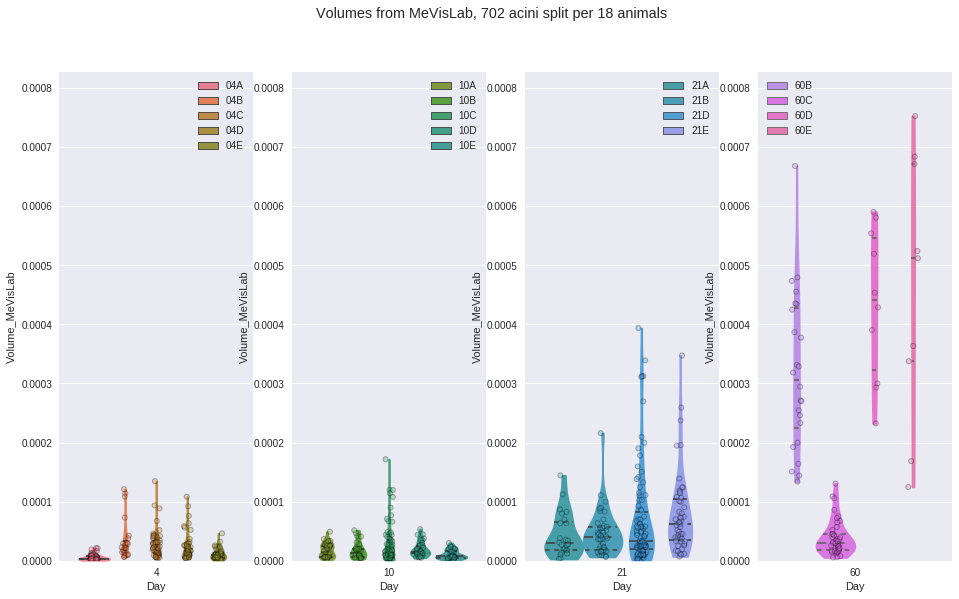

In [51]:
for c, d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1, len(pandas.unique(VolumesFromDisk.Day)), c + 1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d],
                               x='Day', y='Volume_MeVisLab',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d],
                                x='Day', y='Volume_MeVisLab',
                                hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * VolumesFromDisk.Volume_MeVisLab.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Volumes from MeVisLab, %s acini split per %s animals' % (len(VolumesFromDisk),
                                                                       len(pandas.unique(VolumesFromDisk.Animal))))
plt.savefig(os.path.join(imgdir, 'volumes_day-disk.png'), bbox_inches='tight')
plt.show()

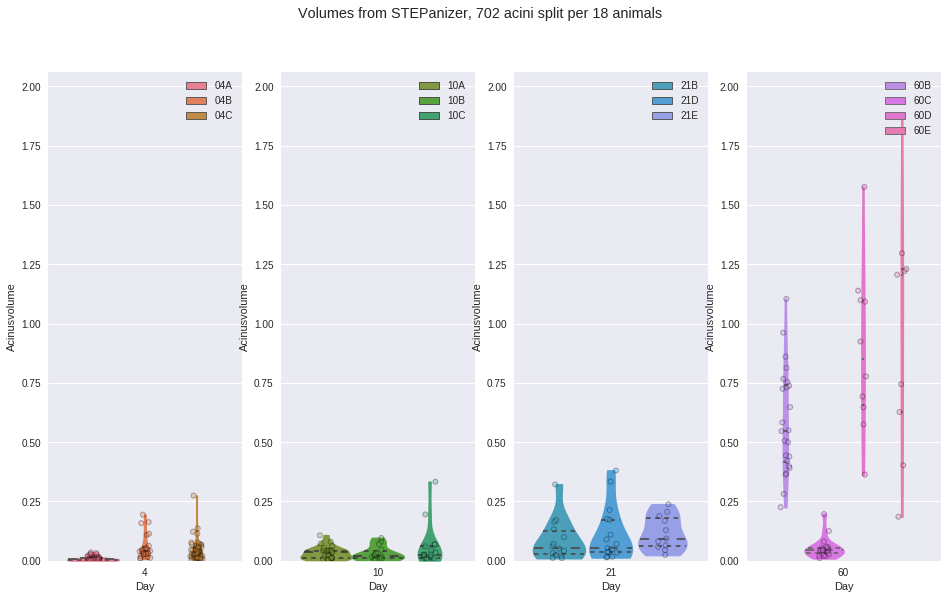

In [52]:
for c, d in enumerate(sorted(pandas.unique(Done.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Acinusvolume',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Acinusvolume', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done.Acinusvolume.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2], loc='upper right')    
plt.suptitle('Volumes from STEPanizer, %s acini split per %s animals' % (len(VolumesFromDisk),
                                                                              len(pandas.unique(VolumesFromDisk.Animal))))
plt.savefig(os.path.join(imgdir, 'volumes_day-disector.png'), bbox_inches='tight')
plt.show()

Now we merge the Eveline/David/Done and VolumesFromDisk dataframes

In [53]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Merged = 'Merged_' + get_git_hash() + '.pkl'

In [54]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This seems to discard all entries that are *not* found in both df's
if os.path.exists(OutputName_Merged):
    # We already did it once, so just load it...
    Merged = pandas.read_pickle(OutputName_Merged)
else:    
    Merged = pandas.merge(Done, VolumesFromDisk)#,
    #                       on=['Animal', 'Acinus', 'Day'],
    #                       how='inner',
    #                       suffixes=('_from_counts', '_from_volume'))

In [55]:
# Doublecheck merged file names (for some randomly selected items from the dataframe)
# To make the checking a bit easier, we split the strings and only show the interesting bit
for i in range(5):
    number = numpy.random.randint(len(Merged))
    print('Beamtime:', Merged.iloc[number]['Beamtime'])
    print('From Volume: Animal', Merged.iloc[number].Filename_Volume.split('mrg.')[0],
          '| Acinus',  Merged.iloc[number].Filename_Volume.split('acinus')[1].split('.volume')[0],
          '| Volume', Merged.iloc[number]['Volume_MeVisLab'])
    print('From Done: Animal', Merged.iloc[number].Filename_Eveline.split('mrg-')[0][1:],
          '| Acinus',  Merged.iloc[number].Filename_Eveline.split('acinus')[1].split('_201')[0],
          '| Counts', Merged.iloc[number]['Counts_Eveline'])
    print(40 * '-')

Beamtime: 2010a
From Volume: Animal R108C04Bt- | Acinus 29 | Volume 6.8696961e-06
From Done: Animal R108C04Bt- | Acinus 29 | Counts 15.0
----------------------------------------
Beamtime: 2009f
From Volume: Animal R108C60Dt- | Acinus 18 | Volume 0.0004532719
From Done: Animal R108C60Dt- | Acinus 18 | Counts 708.0
----------------------------------------
Beamtime: 2010c_tape
From Volume: Animal R108C60B_B1_ | Acinus 29 | Volume 0.00038648456
From Done: Animal R108C60B_B1_ | Acinus 29 | Counts 842.0
----------------------------------------
Beamtime: 2010a
From Volume: Animal R108C10Bt- | Acinus 32 | Volume 9.6822232e-06
From Done: Animal R108C10Bt- | Acinus 32 | Counts 60.0
----------------------------------------
Beamtime: 2010c_tape
From Volume: Animal R108C60B_B1_ | Acinus 2 | Volume 0.00025447792
From Done: Animal R108C60B_B1_ | Acinus 02 | Counts 728.0
----------------------------------------


In [56]:
# Did we count a different amount of images?
Merged['ImageCountDifference'] = Merged['Number of images_David']-Merged['Number of images_Eveline']

In [57]:
# See the difference
Merged.loc[Merged['ImageCountDifference'] == max(Merged['ImageCountDifference'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,...,Area per point,Acinusvolume,Number of images_David,_merge,Location_Volume,Filename_Volume,Volume_MeVisLab,ImageCountDifference,CpV,CpSV
69,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04Bt...,_R108C04Bt-mrg-acinus03_2013-04-09_16-14_resul...,2010a,R108C04Bt-mrg,04B,4,3,93.0,0.68,41,...,11389.9,0.109065,75,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C04Bt-mrg.2932x2932x1024.gvr.acinus3.volum...,0.000042,34,2.188558e+06,852.701528


In [58]:
Merged.head()

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,...,Area per point,Acinusvolume,Number of images_David,_merge,Location_Volume,Filename_Volume,Volume_MeVisLab,ImageCountDifference,CpV,CpSV
0,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus03_2012-06-11_11-49_resul...,2009f,R108C60Dt-mrg,60D,60,3,591.0,2.44,93,...,141125.44,1.098633,93,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C60Dt-mrg.2267.2942.1024.gvr.acinus3.volum...,0.000590,0,1.001645e+06,537.941082
1,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus04_2012-10-19_11-56_resul...,2009f,R108C60Dt-mrg,60D,60,4,750.0,2.17,132,...,130478.41,1.575762,132,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C60Dt-mrg.2267.2942.1024.gvr.acinus4.volum...,0.000554,0,1.354489e+06,475.960304
2,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus07_2012-08-14_15-33_resul...,2009f,R108C60Dt-mrg,60D,60,7,738.0,1.35,120,...,46612.98,0.647100,120,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C60Dt-mrg.2267.2942.1024.gvr.acinus7.volum...,0.000300,0,2.461108e+06,1140.472820
3,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus09_2012-08-14_17-21_resul...,2009f,R108C60Dt-mrg,60D,60,9,554.0,1.49,124,...,55127.13,0.777535,124,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C60Dt-mrg.2267.2942.1024.gvr.acinus9.volum...,0.000390,0,1.419998e+06,712.508034
4,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus10_2012-08-20_16-23_resul...,2009f,R108C60Dt-mrg,60D,60,10,562.0,1.41,110,...,47703.30,0.574691,110,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C60Dt-mrg.2267.2942.1024.gvr.acinus10.volu...,0.000293,0,1.917630e+06,977.916495


In [59]:
if not os.path.exists(OutputName_Merged):
    Merged['CpV'] = Merged['Counts_Eveline'] / Merged['Volume_MeVisLab']

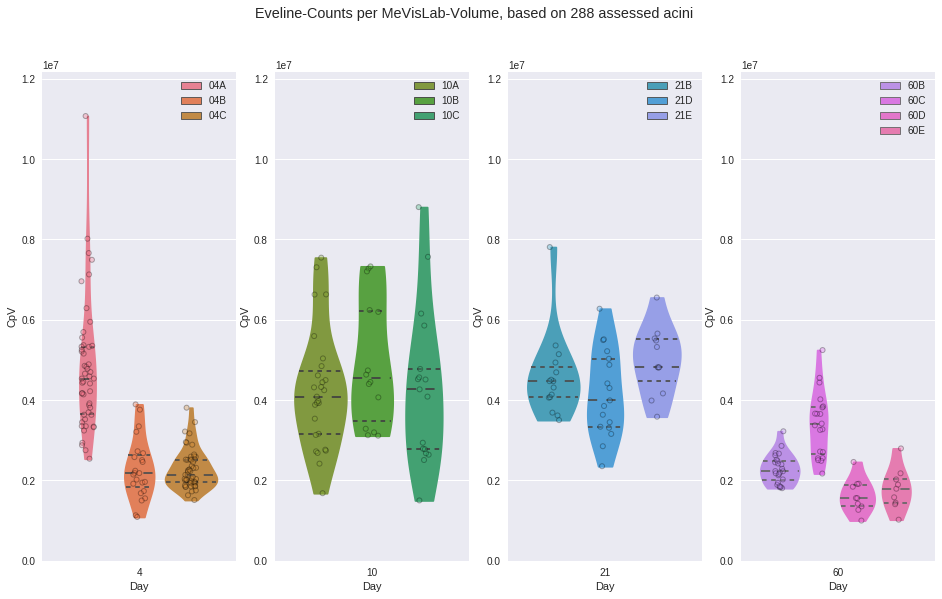

In [60]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                   palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                                hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.CpV.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Eveline-Counts per MeVisLab-Volume, based on %s assessed acini' % len(Merged))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-disk.png'), bbox_inches='tight')
plt.show()

In [61]:
if not os.path.exists(OutputName_Merged):
    Merged['CpSV'] = Merged['Counts_Eveline'] / Merged['Acinusvolume']

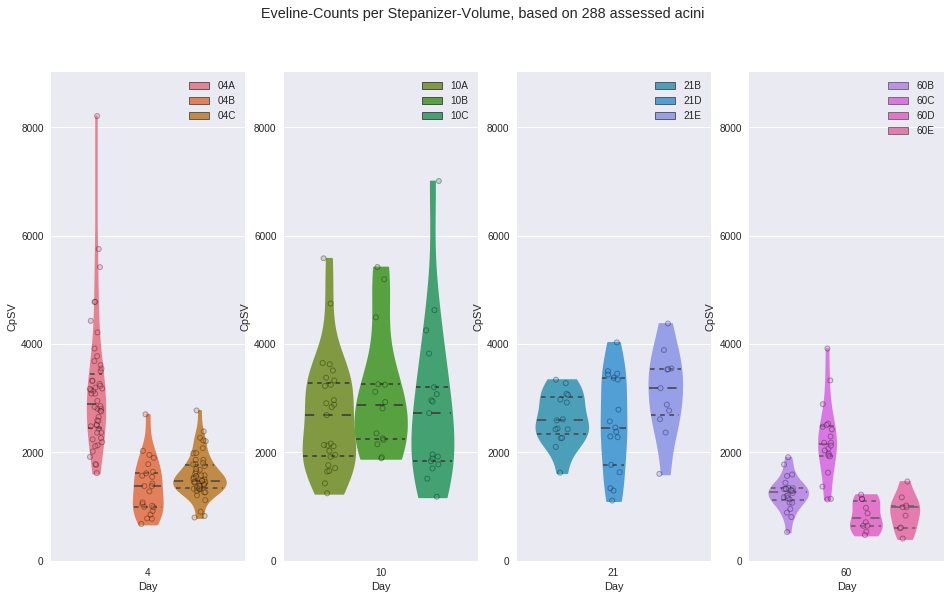

In [62]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpSV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                   palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpSV',
                                hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.CpSV.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Eveline-Counts per Stepanizer-Volume, based on %s assessed acini' % len(Merged))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-stepanizer.png'), bbox_inches='tight')
plt.show()

In [63]:
# Salm zu Barré (d21)
NumAlveoli = 14.303 * 1e6
NumAcini = 5840
NumAlveoli/NumAcini

2449.1438356164385

In [64]:
# Salm zu Barré (d21)
NumAlveoli = 14.303 * 1e6
NumAcini = 5840
NumAlveoli/NumAcini

2449.1438356164385

In [65]:
# Salm zu Barré (d21)
NumAlveoli = 14.303 * 1e6
NumAcini = 5840
NumAlveoli/NumAcini

2449.1438356164385

In [66]:
Eveline[Eveline.Day == 60]['Counts'].describe()

count      63.000000
mean      511.952381
std       335.204725
min        30.000000
25%       148.000000
50%       562.000000
75%       745.000000
max      1296.000000
Name: Counts, dtype: float64

In [67]:
Done['Counts per Volume'] = [cts / vol for cts, vol in zip(Done['Counts_Eveline'], Done['Acinusvolume'])]

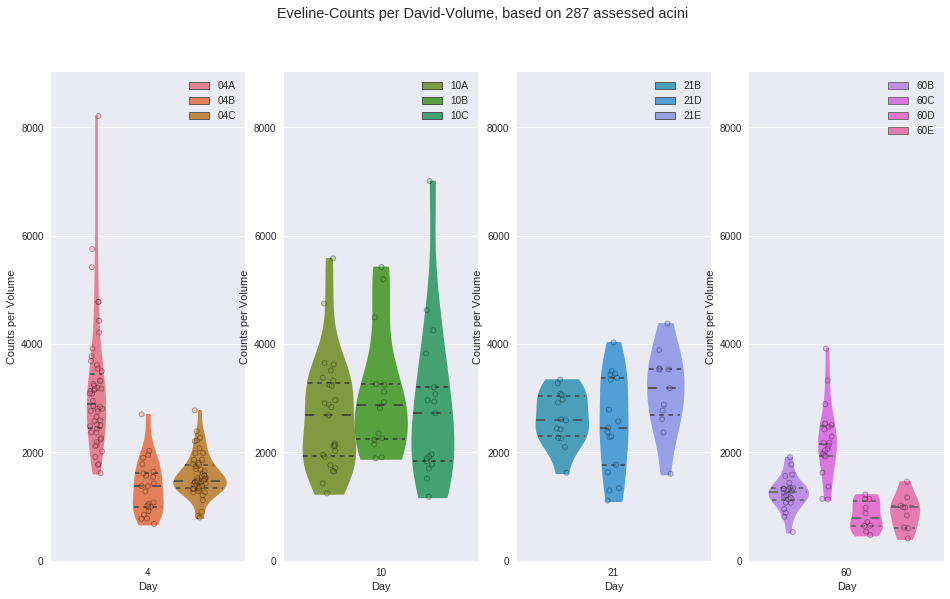

In [68]:
for c, d in enumerate(sorted(pandas.unique(Done.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Counts per Volume',
                               hue='Animal', palette=ourpalette, cut=0, inner='quartiles',
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])))
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Counts per Volume', hue='Animal', jitter=True,
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])))
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done['Counts per Volume'].max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2], loc='upper right')    
plt.suptitle('Eveline-Counts per David-Volume, based on %s assessed acini' % len(Done))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-david.png'), bbox_inches='tight')
plt.show()

In [75]:
Done.loc[Done['Counts per Volume'] == max(Done['Counts per Volume'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,Location_David,Filename_David,Counts_David,Pixelsize_David,Area per point,Acinusvolume,Number of images_David,_merge,Counts per Volume
34,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...,_R108C04At-mrg-acinus43_2013-04-02_14-02_resul...,2010a,R108C04At-mrg,04A,4,43,35.0,0.22,28,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...,_R108C04At-mrg-acinus43_2018-02-12_14-20_resul...,232,0.19,1241.89,0.004264,28,both,8207.959673


In [70]:
Done.loc[Done['Counts per Volume'] == min(Done['Counts per Volume'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,Location_David,Filename_David,Counts_David,Pixelsize_David,Area per point,Acinusvolume,Number of images_David,_merge,Counts per Volume
14,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Et...,_R108C60Et-mrg-acinus08_2012-09-27_13-47_resul...,2009f,R108C60Et-mrg,60E,60,8,770.0,2.17,141,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Et...,_R108C60Et-mrg-acinus08_2018-02-02_15-51_resul...,1086,1.82,116632.6,1.874612,141,both,410.751566


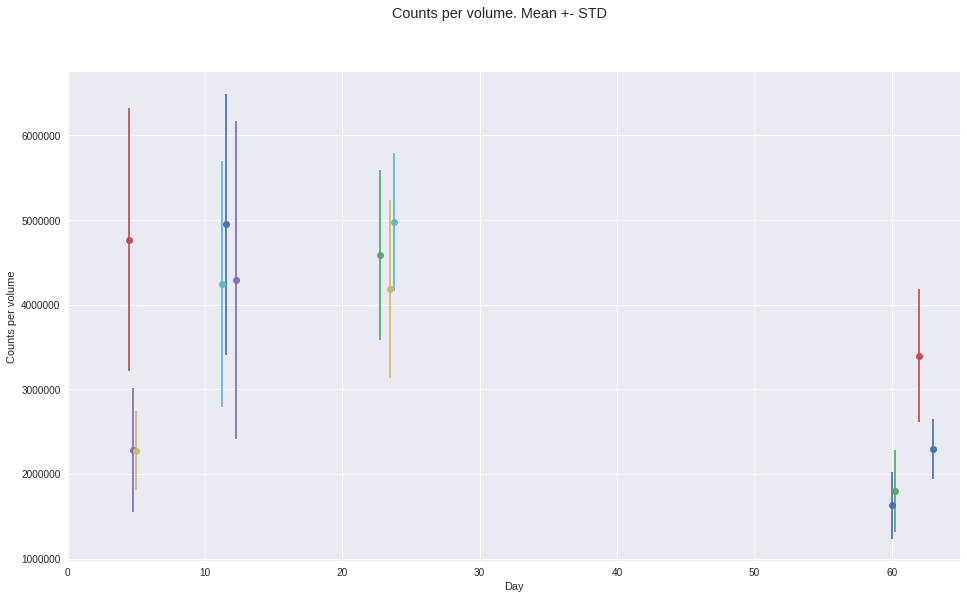

In [71]:
# Plot mean +- STD
for c, d in enumerate(pandas.unique(Merged.Animal)):
    #     print(d)
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['Day']))
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    #     print(numpy.std(Merged.loc[Merged.Animal == d]['CpV']))
    #     plt.scatter(numpy.mean(Merged.loc[Merged.Animal == d]['Day']), numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    plt.errorbar(numpy.mean(Merged.loc[Merged.Animal == d]['Day']) + 0.25 * c % 5,
                 numpy.mean(Merged.loc[Merged.Animal == d]['CpV']),
                 yerr=numpy.std(Merged.loc[Merged.Animal == d]['CpV']),
                 fmt='o')
    plt.xlabel('Day')
    plt.ylabel('Counts per volume')
    plt.xlim([0, 65])
plt.suptitle('Counts per volume. Mean +- STD')   
plt.savefig(os.path.join(imgdir, 'mean_counts.png'), bbox_inches='tight')
plt.show()

In [72]:
# Get the mean number of alveoli per acinus
print('Based on Tschanz2014 and Barre2014...')
# Number of alveoli (19.297e6) from Tschanz2014, Table 1, p. 91)
# Number of acini (5943) from Barre2014, Table 2, p. 7 
n_alv = 19.279 * 1e6
n_acini = 5943
alv_pro_acinus = n_alv / n_acini
print('We have approximately %0.0f alveoli per acinus.' % alv_pro_acinus)
lung_volume = 10.21  # cm³
acinar_volume = lung_volume / n_acini
print('One acinus in D60 lungs thus has a volume of approximately %0.2g um^3.' % acinar_volume)

Based on Tschanz2014 and Barre2014...
We have approximately 3244 alveoli per acinus.
One acinus in D60 lungs thus has a volume of approximately 0.0017 um^3.


In [73]:
for d in [4,10,21,60]:
    print('For day %2s we have %3s acini' % (d, len(Merged[Merged.Day==d])))

For day  4 we have 124 acini
For day 10 we have  58 acini
For day 21 we have  43 acini
For day 60 we have  63 acini


In [74]:
# Save the data
if not os.path.exists(OutputName_Merged):
    Merged.to_pickle(OutputName_Merged)
    print('Saved "Merged" dataframe to %s as last step of the analysis' % OutputName_Merged)
else:
    print('Done!')

Done!
